<a href="https://colab.research.google.com/github/MahirMahbub/Financial-Sentiment-Ananlysis-and-Topic-Modeling/blob/main/FinBert_Sentiment_%26_Topic_Modeling_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Generation

In [ ]:
!pip install transformers


In [ ]:
! pip install lazypredict

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline



In [ ]:
def model_loader(load_model: str = 'yiyanghkust/finbert-tone', task_type:str = "sentiment-analysis"):
  finbert = BertForSequenceClassification.from_pretrained(load_model,num_labels=3)
  tokenizer = BertTokenizer.from_pretrained(load_model)
  nlp = pipeline(task_type, model=finbert, tokenizer=tokenizer)
  return nlp

In [ ]:
def predictor(pipe_line, sentences):
  results = pipe_line(sentences)
  label_tag = {"LABEL_0": "neutral", "LABEL_1": "positive", "LABEL_2": "negative"}
  results = [{'label': label_tag[res["label"]], 'score':res["score"]}for res in results]
  return results

# TEST FinBert MODEL

In [ ]:

import json
sentences = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat",
             "Pre-tax loss totaled euro 0.3 million, compared to a loss of euro 2.2 million in the first quarter of 2005",
             "This implementation is very important to the operator, since it is about to launch its Fixed to Mobile convergence service in Brazil",
             "The situation of coated magazine printing paper will continue to be weak"]
pipe_line = model_loader()
results = predictor(pipe_line, sentences)
print(json.dumps(results, indent=4))

[
    {
        "label": "negative",
        "score": 0.9966173768043518
    },
    {
        "label": "positive",
        "score": 1.0
    },
    {
        "label": "negative",
        "score": 0.9999710321426392
    },
    {
        "label": "neutral",
        "score": 0.9889442920684814
    },
    {
        "label": "neutral",
        "score": 0.7256450653076172
    },
    {
        "label": "neutral",
        "score": 0.9984122514724731
    },
    {
        "label": "negative",
        "score": 0.9999972581863403
    }
]


# Topic Identification

In [ ]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 3.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
! pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.7 MB 4.0 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.0.0-py2.py3-none-any.whl size=136730 sha256=ff18420660080fd30a191d263c5195e85bf138a240d46bf363c92c40b2fac720
  Stored in directory: /root/.cache/pip/wheels/4b/9a/85/10dbb62679c05c3d84213be737ff3ca1ec420691033e6fcdcf
Successfully built pyLDAvis
  Attempting uninstall: pyLDAvis
    Found existing installation: pyLDAvis 2.0.0
    Uninstalling pyLDAvis-2.0.0:
      Successfully uninstalled pyLDAvis-2.0.0


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
"""
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
pprint(data[:1])
"""

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/reg_follow.csv', header=0)
print(df.head())

                                               title  ...                                        description
0             Transfer Pricing Brief: September 2021  ...  China APAs-Unilateral: On 26 July 2021: the St...
1  Germany publishes Guidance on MAP and arbitrat...  ...  On 27 August 2021: the Federal Ministry of Fin...
2                   Denmark presents Budget for 2022  ...  On 30 August 2021: the Minister of Finance pre...
3  Qatar: GTA extends deadline for filing tax ret...  ...  On 30 August 2021: the General Tax Authority (...
4  US: IRS publishes joint statement with Germany...  ...  The Internal Revenue Service (IRS) published a...

[5 rows x 5 columns]


In [ ]:
data = df.description.values.tolist()
data

['China APAs-Unilateral: On 26 July 2021: the State Administration of Taxation (SAT) issued Announcement No. 24 (2021) that finalizes a simplified procedure for unilateral advance pricing arrangements (APAs): which will come into effect on 1 &#8230;',
 'On 27 August 2021: the Federal Ministry of Finance published guidance on mutual agreement (MAP) and arbitration procedures. The guide explains how to initiate procedures: how to carry out procedures: how to execute agreements: etc. &#8230;',
 'On 30 August 2021: the Minister of Finance presented the government&#8217;s budget proposal for 2022. With its proposal for the Finance Act 2022: most of the measures presented focus on easing the country&#8217;s transition out &#8230;',
 'On 30 August 2021: the General Tax Authority (GTA) of Qatar has announced the extension of deadline for submitting tax returns for fiscal year 2020 for companies and establishments owned by Qatari citizens and GCC &#8230;',
 'The Internal Revenue Service (IRS) p

In [ ]:
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
pprint(data[:1])

['China APAs-Unilateral: On 26 July 2021: the State Administration of Taxation '
 '(SAT) issued Announcement No. 24 (2021) that finalizes a simplified '
 'procedure for unilateral advance pricing arrangements (APAs): which will '
 'come into effect on 1 &#8230;']


<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<input>:1: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \s
<ipython-input-130-6b9fa7375985>:1: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-130-6b9fa7375985>:4: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+

In [ ]:
pprint(data[:10])

['China APAs-Unilateral: On 26 July 2021: the State Administration of Taxation '
 '(SAT) issued Announcement No. 24 (2021) that finalizes a simplified '
 'procedure for unilateral advance pricing arrangements (APAs): which will '
 'come into effect on 1 &#8230;',
 'On 27 August 2021: the Federal Ministry of Finance published guidance on '
 'mutual agreement (MAP) and arbitration procedures. The guide explains how to '
 'initiate procedures: how to carry out procedures: how to execute agreements: '
 'etc. &#8230;',
 'On 30 August 2021: the Minister of Finance presented the government&#8217;s '
 'budget proposal for 2022. With its proposal for the Finance Act 2022: most '
 'of the measures presented focus on easing the country&#8217;s transition out '
 '&#8230;',
 'On 30 August 2021: the General Tax Authority (GTA) of Qatar has announced '
 'the extension of deadline for submitting tax returns for fiscal year 2020 '
 'for companies and establishments owned by Qatari citizens and GCC &#82

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['china', 'apas', 'unilateral', 'on', 'july', 'the', 'state', 'administration', 'of', 'taxation', 'sat', 'issued', 'announcement', 'no', 'that', 'finalizes', 'simplified', 'procedure', 'for', 'unilateral', 'advance', 'pricing', 'arrangements', 'apas', 'which', 'will', 'come', 'into', 'effect', 'on']]


In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['china', 'apas', 'unilateral', 'on', 'july', 'the', 'state', 'administration', 'of', 'taxation', 'sat', 'issued', 'announcement', 'no', 'that', 'finalizes', 'simplified', 'procedure', 'for', 'unilateral', 'advance_pricing', 'arrangements', 'apas', 'which', 'will', 'come', 'into', 'effect', 'on']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

[['taxation', 'sit', 'issue', 'announcement', 'finalize', 'simplify', 'procedure', 'unilateral', 'advance', 'pricing', 'arrangement', 'apa', 'come', 'effect']]


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

In [ ]:
print(data_lemmatized[:1])

[['taxation', 'sit', 'issue', 'announcement', 'finalize', 'simplify', 'procedure', 'unilateral', 'advance', 'pricing', 'arrangement', 'apa', 'come', 'effect']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


In [ ]:
id2word[0]

'advance'

In [ ]:
texts

[['taxation',
  'sit',
  'issue',
  'announcement',
  'finalize',
  'simplify',
  'procedure',
  'unilateral',
  'advance',
  'pricing',
  'arrangement',
  'apa',
  'come',
  'effect'],
 ['finance',
  'publish',
  'mutual',
  'agreement',
  'map',
  'arbitration',
  'procedure',
  'guide',
  'explain',
  'initiate',
  'procedure',
  'carry',
  'procedure',
  'execute',
  'agreement'],
 ['finance',
  'present',
  'government',
  'budget',
  'finance',
  'act',
  'measure',
  'present',
  'focus',
  'ease',
  'country',
  'transition'],
 ['announce',
  'extension',
  'deadline',
  'submit',
  'tax',
  'return',
  'fiscal',
  'year',
  'company',
  'establishment',
  'own',
  'qatari',
  'citizen',
  'gcc'],
 ['publish', 'joint', 'country'],
 ['publish', 'joint'],
 ['virtual',
  'brics',
  'ministerial',
  'meeting',
  'environment',
  'state',
  'joint',
  'opposition',
  'propose',
  'carbon',
  'adjustment',
  'mechanism',
  'refer',
  'discriminatory',
  'bric',
  'country'],
 ['finan

# USING LDA

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

NameError: ignored

In [ ]:
pprint(ldamallet.show_topics(formatted=False))

# Using MALLET

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2021-09-08 11:05:40--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.2’

mallet-2.0.8.zip.2  100%[===================>]  15.43M  10.0MB/s    in 1.5s    

2021-09-08 11:05:41 (10.0 MB/s) - ‘mallet-2.0.8.zip.2’ saved [16184794/16184794]



In [ ]:
! unzip /content/mallet-2.0.8.zip

Archive:  /content/mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Initial Try with Mallet

In [ ]:
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, iterations=3000)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


KeyboardInterrupt: ignored

In [ ]:
pprint(ldamallet.show_topics(formatted=False))

In [ ]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

# Find Optimal Topic Number

## Using Mallet

In [ ]:
def compute_coherence_values_mallet(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, iterations=1000)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coh = coherencemodel.get_coherence()
        print(coh)
        coherence_values.append(coh)

    return model_list, coherence_values

## Using LDA

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coh = coherencemodel.get_coherence()
        print(coh)
        coherence_values.append(coh)

    return model_list, coherence_values

# Using Mallet

In [ ]:
model_list_mallet, coherence_values_mallet = compute_coherence_values_mallet(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=6)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


0.28230286685510153


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


0.4096237460245289


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


0.47578410995045534


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


0.5089857800941605


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


0.5765699534423874


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


0.5874448809047876


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


0.5993806312539556


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


0.6252372581577521


# Using LDA

In [ ]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore')
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=6)


# Using Mallet

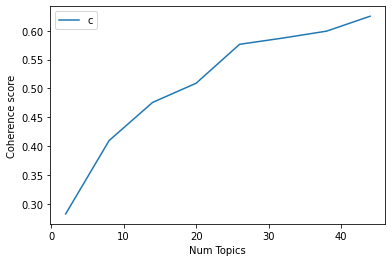

In [ ]:
limit=50; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_mallet)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values_mallet):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2823
Num Topics = 8  has Coherence Value of 0.4096
Num Topics = 14  has Coherence Value of 0.4758
Num Topics = 20  has Coherence Value of 0.509
Num Topics = 26  has Coherence Value of 0.5766
Num Topics = 32  has Coherence Value of 0.5874
Num Topics = 38  has Coherence Value of 0.5994
Num Topics = 44  has Coherence Value of 0.6252


# Using LDA

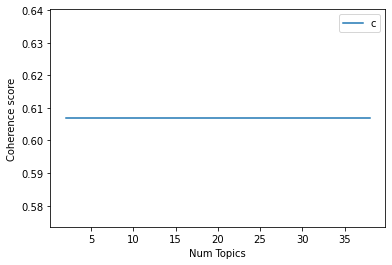

In [ ]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: ignored

# Optimal Topic (LDA)

In [ ]:
optimal_topic = 10
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

# Optimal Topic (Mallet)

In [ ]:
optimal_topic = 24
lda_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=optimal_topic, id2word=id2word, iterations=1000)
# lda_model.train(corpus=corpus)


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
pprint(ldamallet.show_topics(formatted=False, num_topics = 24, num_words=5))

[(0,
  [('return', 0.25396825396825395),
   ('deadline', 0.23809523809523808),
   ('extend', 0.23015873015873015),
   ('submission', 0.09523809523809523),
   ('meeting', 0.015873015873015872)]),
 (1,
  [('cit', 0.1262135922330097),
   ('corporate', 0.11650485436893204),
   ('cbc', 0.10679611650485436),
   ('incentive', 0.07766990291262135),
   ('year', 0.07766990291262135)]),
 (2,
  [('tax', 0.36633663366336633),
   ('file', 0.13861386138613863),
   ('rule', 0.09900990099009901),
   ('economy', 0.039603960396039604),
   ('extension', 0.039603960396039604)]),
 (3,
  [('issue', 0.33636363636363636),
   ('guidance', 0.15454545454545454),
   ('revenue', 0.08181818181818182),
   ('circular', 0.045454545454545456),
   ('develop', 0.03636363636363636)]),
 (4,
  [('payment', 0.15841584158415842),
   ('make', 0.0891089108910891),
   ('public', 0.0891089108910891),
   ('reduce', 0.07920792079207921),
   ('regard', 0.06930693069306931)]),
 (5,
  [('tax', 0.46788990825688076),
   ('fiscal', 0.0550

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data, default="mallet"):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        if default == "mallet":
          row = sorted(row, key=lambda x: (x[1]), reverse=True)
        else: 
          row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant top 3 topic
                wp = ldamodel.show_topic(topic_num)
                print(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

# Using Topic (LDA)

In [ ]:
# Top 1
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data, default="lda")

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print(df_dominant_topic)


     Document_No  ...                                               Text
0              0  ...             Transfer Pricing Brief: September 2021
1              1  ...  Germany publishes Guidance on MAP and arbitrat...
2              2  ...                   Denmark presents Budget for 2022
3              3  ...  Qatar: GTA extends deadline for filing tax ret...
4              4  ...  US: IRS publishes joint statement with Germany...
..           ...  ...                                                ...
487          487  ...  OECD: Public Consultation on Tax Challenges of...
488          488  ...                         Sri Lanka: Budget for 2021
489          489  ...            Italy extends DST deadlines for FY 2020
490          490  ...  Thailand: Tax authority prolongs e-Filing dead...
491          491  ...  France: Supreme Administrative Court makes a d...

[492 rows x 5 columns]


In [ ]:
print(df_dominant_topic.iloc[:, 1:4])
print(len(corpus))

     Dominant_Topic  ...                                           Keywords
0               2.0  ...  decision, make, publish, dispute, tp, report, ...
1               2.0  ...  decision, make, publish, dispute, tp, report, ...
2               3.0  ...  issue, year, guidance, development, relief, pa...
3               0.0  ...  deadline, extend, return, extension, file, pro...
4               2.0  ...  decision, make, publish, dispute, tp, report, ...
..              ...  ...                                                ...
487             3.0  ...  issue, year, guidance, development, relief, pa...
488             0.0  ...  deadline, extend, return, extension, file, pro...
489             0.0  ...  deadline, extend, return, extension, file, pro...
490             0.0  ...  deadline, extend, return, extension, file, pro...
491             2.0  ...  decision, make, publish, dispute, tp, report, ...

[492 rows x 3 columns]
492


In [ ]:
# !pip install pyldavis==2.0.0 numexpr



     |████████████████████████████████| 2.2 MB 27.9 MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.0.0-py2.py3-none-any.whl size=97472 sha256=c2aa9a08e70f45e29dc99d39acd6dcee460d00d045137b09abb9b6358835fa02
  Stored in directory: /root/.cache/pip/wheels/90/6a/ce/318436e940fd8e6ec16869a7d5fe77827c927557a3cf4f647e
Successfully built pyldavis
  Attempting uninstall: pyldavis
    Found existing installation: pyLDAvis 3.3.1
    Uninstalling pyLDAvis-3.3.1:
      Successfully uninstalled pyLDAvis-3.3.1


In [ ]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

AttributeError: ignored

# Using Topic (Mallet)

In [ ]:
# Top 1
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
print(df_dominant_topic)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


19
2
17
7
6
21
16
16
11
4
3
3
8
23
11
2
12
13
13
6
3
5
17
21
16
3
6
7
20
10
18
8
17
23
10
0
15
23
2
17
11
7
21
10
12
23
10
4
14
17
16
19
6
16
19
10
22
19
0
9
14
8
12
16
6
0
11
13
0
0
0
0
7
8
11
15
1
8
11
11
15
16
3
22
21
5
17
10
15
7
21
10
9
6
6
23
4
4
13
15
9
23
19
4
4
11
16
10
10
17
9
17
2
15
6
23
7
2
7
1
19
23
20
17
9
16
10
1
12
6
14
2
13
2
12
20
21
5
15
6
22
7
18
16
2
6
7
18
12
21
7
17
2
22
8
4
2
13
17
2
16
2
6
4
5
6
19
5
15
12
12
8
23
9
14
4
15
15
16
3
5
19
6
22
3
6
21
4
6
21
0
13
23
14
23
10
18
7
12
1
21
7
7
5
22
20
12
23
10
16
1
21
10
16
7
17
16
9
7
15
3
9
2
14
7
3
10
10
21
7
11
7
14
3
7
12
18
17
9
12
16
16
23
2
10
3
1
10
14
8
7
13
21
10
5
19
2
5
5
12
13
6
7
22
8
0
7
19
10
22
22
16
7
23
5
16
0
8
9
7
23
12
10
9
15
10
20
7
10
22
11
17
19
8
9
2
5
13
0
9
15
17
12
2
12
7
11
16
19
16
8
2
14
5
19
16
19
16
2
13
7
7
7
22
6
10
1
7
17
14
4
14
19
3
7
1
0
7
22
20
22
14
21
10
14
20
5
7
22
7
9
19
7
21
0
10
16
1
21
18
9
12
2
3
6
7
22
19
5
20
6
12
10
18
15
12
5
16
1
10
1
7
11
15
18
2
19
17
12
11

In [ ]:
pprint(data[:5])

['China APAs-Unilateral: On 26 July 2021: the State Administration of Taxation '
 '(SAT) issued Announcement No. 24 (2021) that finalizes a simplified '
 'procedure for unilateral advance pricing arrangements (APAs): which will '
 'come into effect on 1 &#8230;',
 'On 27 August 2021: the Federal Ministry of Finance published guidance on '
 'mutual agreement (MAP) and arbitration procedures. The guide explains how to '
 'initiate procedures: how to carry out procedures: how to execute agreements: '
 'etc. &#8230;',
 'On 30 August 2021: the Minister of Finance presented the government&#8217;s '
 'budget proposal for 2022. With its proposal for the Finance Act 2022: most '
 'of the measures presented focus on easing the country&#8217;s transition out '
 '&#8230;',
 'On 30 August 2021: the General Tax Authority (GTA) of Qatar has announced '
 'the extension of deadline for submitting tax returns for fiscal year 2020 '
 'for companies and establishments owned by Qatari citizens and GCC &#82

In [ ]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
  print(df_dominant_topic)
  print(len(corpus))

     Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0              0           19.00                0.14   
1              1            2.00                0.15   
2              2           17.00                0.09   
3              3            7.00                0.08   
4              4            6.00                0.06   
..           ...             ...                 ...   
487          487           16.00                0.15   
488          488           19.00                0.12   
489          489           18.00                0.07   
490          490            7.00                0.09   
491          491            9.00                0.13   

                                              Keywords  \
0    rule, budget, announcement, release, parliamen...   
1    measure, agreement, implement, enter, procedur...   
2    finance, bill, propose, amendment, follow, acc...   
3    deadline, return, extend, extension, due, annu...   
4    country, report, cbc, introduce,

In [ ]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim as gensimvis
import pyLDAvis.sklearn
import gensim  
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))  
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model)

vis = gensimvis.prepare(model, corpus, id2word)
pyLDAvis.enable_notebook()
# vis
viz = pyLDAvis.display(vis)
from IPython.core.display import HTML
# HTML(viz)
pyLDAvis.display(vis)

In [ ]:
lda_model.save('/content/drive/MyDrive/Model/lda_train_mallet.model')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
%matplotlib inline
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    # print(row_list)
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values
#print(arr)
# Keep the well separated points (optional)
# arr = arr[np.amax(arr, axis=1) > 0.35]
# print(arr)
# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.15, init='pca', n_iter=10000, perplexity=15)
tsne_lda = tsne_model.fit_transform(arr)
print(type(tsne_lda))
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 20
mycolors = np.array([color for name, color in mcolors.CSS4_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 492 samples in 0.002s...
[t-SNE] Computed neighbors for 492 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 492 / 492
[t-SNE] Mean sigma: 0.025247
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.089157
[t-SNE] KL divergence after 10000 iterations: 1.047026
<class 'numpy.ndarray'>


# Topic Classifier

In [ ]:

train_vecs = []
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model)
for i in range(len(corpus)):
    top_topics = model.get_document_topics(corpus[i], minimum_probability=0.0)
    print(top_topics)
    topic_vec = [top_topics[i][1] for i in range(optimal_topic)]
    # topic_vec.extend([len(rev_train.iloc[i].text)]) # length review
    train_vecs.append(topic_vec)

[(0, 0.033068783068783074), (1, 0.03420214591912676), (2, 0.04852975106678977), (3, 0.033068783068783074), (4, 0.033068783068783074), (5, 0.05422090944878561), (6, 0.033068783068783074), (7, 0.04926043123098316), (8, 0.033068783068783074), (9, 0.033068783068783074), (10, 0.03863845798924118), (11, 0.033068783068783074), (12, 0.033068783068783074), (13, 0.033068783068783074), (14, 0.04310301380168674), (15, 0.03364369162613958), (16, 0.0346704607487054), (17, 0.033068783068783074), (18, 0.033068783068783074), (19, 0.13626038865249945), (20, 0.033068783068783074), (21, 0.03914180090846689), (22, 0.0435417393821769), (23, 0.0479618124000018)]
[(0, 0.03205128205128205), (1, 0.03794830501553369), (2, 0.15413067426360516), (3, 0.06282051282051282), (4, 0.04743589743589743), (5, 0.033227096961771486), (6, 0.03205128205128205), (7, 0.03205128205128205), (8, 0.03205128205128205), (9, 0.03205128205128205), (10, 0.03205128205128205), (11, 0.03205128205128205), (12, 0.03205128205128205), (13, 0.03

In [ ]:
pprint(train_vecs)
# df_dominant_topic

Streaming output truncated to the last 5000 lines.
  0.0336021505376344,
  0.03547514175550734,
  0.0336021505376344,
  0.06657005777702973,
  0.0336021505376344,
  0.0336021505376344,
  0.0336021505376344,
  0.06490668461097822],
 [0.031094527363184077,
  0.061371780443485326,
  0.03115178889838068,
  0.031094527363184077,
  0.06094527363184079,
  0.031094527363184077,
  0.04572209548249678,
  0.031094527363184077,
  0.03679644592085307,
  0.046677742914892226,
  0.07143310827130502,
  0.031094527363184077,
  0.031094527363184077,
  0.03249059228100109,
  0.05390567109304948,
  0.07623525232598237,
  0.05524335507417179,
  0.031094527363184077,
  0.031094527363184077,
  0.031094527363184077,
  0.04506536471644705,
  0.036968975657574024,
  0.031094527363184077,
  0.03504727965667938],
 [0.035393215799209066,
  0.03173924218347441,
  0.03160296681976685,
  0.03156565656565657,
  0.03156565656565657,
  0.03156565656565657,
  0.0465811017402492,
  0.03156565656565657,
  0.031565656565656

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

In [ ]:
X = np.array(train_vecs)
y = np.array(df_dominant_topic.Dominant_Topic)

In [ ]:


kf = KFold(5, shuffle=True, random_state=42)
cv_lr_f1, cv_lrsgd_f1, cv_svcsgd_f1, cv_mlp_f1, cv_knn_f1  = [], [], [], [], []

for train_ind, val_ind in kf.split(X, y):
    # Assign CV IDX
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind]
    
    # # Scale Data
    # scaler = StandardScaler()
    # X_train_scale = scaler.fit_transform(X_train)
    # X_val_scale = scaler.transform(X_val)
    X_train_scale = X_train
    X_val_scale = X_val
    # Logisitic Regression
    lr = LogisticRegression(
        class_weight= 'balanced',
        solver='newton-cg',
        fit_intercept=True
    ).fit(X_train_scale, y_train)
    y_pred = lr.predict(X_val_scale)
    cv_lr_f1.append(f1_score(y_val, y_pred, average='micro'))

    # MLP Classifier
    lr = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(1000,), 
                    random_state=1, max_iter=2000, solver = "adam", early_stopping=True, n_iter_no_change = 50).fit(X_train_scale, y_train)
    y_pred = lr.predict(X_val_scale)
    cv_mlp_f1.append(f1_score(y_val, y_pred, average='micro'))
    
    # Logistic Regression SGD
    sgd = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        loss='log',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd.predict(X_val_scale)
    cv_lrsgd_f1.append(f1_score(y_val, y_pred, average='micro'))
    
    # SGD Modified Huber
    sgd_huber = linear_model.SGDClassifier(
        max_iter=1000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber',
        class_weight='balanced'
    ).fit(X_train_scale, y_train)
    
    y_pred = sgd_huber.predict(X_val_scale)
    cv_svcsgd_f1.append(f1_score(y_val, y_pred, average='micro'))

    # KNN Classifier
    
    from sklearn.neighbors import KNeighborsClassifier
    lr = KNeighborsClassifier(n_neighbors=8).fit(X_train_scale, y_train)
    y_pred = lr.predict(X_val_scale)
    cv_knn_f1.append(f1_score(y_val, y_pred, average='micro'))

print(f'MLP Val f1: {np.mean(cv_mlp_f1):.3f} +- {np.std(cv_mlp_f1):.3f}')
print(f'Logistic Regression Val f1: {np.mean(cv_lr_f1):.3f} +- {np.std(cv_lr_f1):.3f}')
print(f'Logisitic Regression SGD Val f1: {np.mean(cv_lrsgd_f1):.3f} +- {np.std(cv_lrsgd_f1):.3f}')
print(f'SVM Huber Val f1: {np.mean(cv_svcsgd_f1):.3f} +- {np.std(cv_svcsgd_f1):.3f}')
print(f'KNN Val f1: {np.mean(cv_knn_f1):.3f} +- {np.std(cv_knn_f1):.3f}')

MLP Val f1: 0.782 +- 0.033
Logistic Regression Val f1: 0.845 +- 0.025
Logisitic Regression SGD Val f1: 0.398 +- 0.105
SVM Huber Val f1: 0.051 +- 0.023
KNN Val f1: 0.787 +- 0.014


In [ ]:
import pickle


with open('/content/drive/MyDrive/Dataset/train_dataset.pickle', 'wb') as output:
    pickle.dump(X, output)
with open('/content/drive/MyDrive/Dataset/train_label_dataset.pickle', 'wb') as output:
    pickle.dump(y, output)

with open('/content/drive/MyDrive/Dataset/train_dataset.pickle', 'rb') as data:
    dataset = pickle.load(data)
    print(dataset)

[[0.03306878 0.03420215 0.04852975 ... 0.0391418  0.04354174 0.04796181]
 [0.03205128 0.03794831 0.15413067 ... 0.03631653 0.03974276 0.0324796 ]
 [0.03360215 0.03374678 0.05391923 ... 0.03360215 0.03360215 0.06621569]
 ...
 [0.05733785 0.03942034 0.06543716 ... 0.03783067 0.03360215 0.0354601 ]
 [0.03360215 0.03360215 0.03360215 ... 0.04936306 0.03360215 0.03360215]
 [0.06723052 0.03531073 0.03611992 ... 0.03531073 0.03531073 0.03531073]]


k = 7 KNN Val f1: 0.655 +- 0.024


k = 8 KNN Val f1: 0.669 +- 0.037


k = 9 KNN Val f1: 0.650 +- 0.046


k = 10 KNN Val f1: 0.652 +- 0.053

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pickle
import pprint



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
try:
  X = np.array(train_vecs)
  y = np.array(df_dominant_topic.Dominant_Topic)
except Exception as e:
  with open('/content/drive/MyDrive/Dataset/train_dataset.pickle', 'rb') as data:
    X = pickle.load(data)
  with open('/content/drive/MyDrive/Dataset/train_label_dataset.pickle', 'rb') as data:
    y = pickle.load(data)
print(X,y)
  

[[0.03306878 0.03420215 0.04852975 ... 0.0391418  0.04354174 0.04796181]
 [0.03205128 0.03794831 0.15413067 ... 0.03631653 0.03974276 0.0324796 ]
 [0.03360215 0.03374678 0.05391923 ... 0.03360215 0.03360215 0.06621569]
 ...
 [0.05733785 0.03942034 0.06543716 ... 0.03783067 0.03360215 0.0354601 ]
 [0.03360215 0.03360215 0.03360215 ... 0.04936306 0.03360215 0.03360215]
 [0.06723052 0.03531073 0.03611992 ... 0.03531073 0.03531073 0.03531073]] [19.  2. 17.  7.  6. 21. 16. 16. 11.  4.  3.  3.  8. 23. 11.  2. 12. 13.
 13.  6.  3.  5. 17. 21. 16.  3.  6.  7. 20. 10. 18.  8. 17. 23. 10.  0.
 15. 23.  2. 17. 11.  7. 21. 10. 12. 23. 10.  4. 14. 17. 16. 19.  6. 16.
 19. 10. 22. 19.  0.  9. 14.  8. 12. 16.  6.  0. 11. 13.  0.  0.  0.  0.
  7.  8. 11. 15.  1.  8. 11. 11. 15. 16.  3. 22. 21.  5. 17. 10. 15.  7.
 21. 10.  9.  6.  6. 23.  4.  4. 13. 15.  9. 23. 19.  4.  4. 11. 16. 10.
 10. 17.  9. 17.  2. 15.  6. 23.  7.  2.  7.  1. 19. 23. 20. 17.  9. 16.
 10.  1. 12.  6. 14.  2. 13.  2. 12. 20. 21. 

In [ ]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state =123)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
y_train = list(map(int, y_train))
y_test = list(map(int, y_test))
print(X_train, X_test, y_train, y_test )

[[0.05378294 0.03430001 0.05015973 ... 0.03415301 0.05009662 0.03415301]
 [0.03360215 0.03370858 0.03370858 ... 0.04973118 0.03697571 0.03360215]
 [0.03306878 0.03420215 0.04852975 ... 0.0391418  0.04354174 0.04796181]
 ...
 [0.04088775 0.03306878 0.03306878 ... 0.03306878 0.03306878 0.03306878]
 [0.03635079 0.0460199  0.04439618 ... 0.03109453 0.03109453 0.03126082]
 [0.03415301 0.03415301 0.03415301 ... 0.0614043  0.03415301 0.03415301]] [[0.03255208 0.03255208 0.03255208 ... 0.03255208 0.03255208 0.03255208]
 [0.03063725 0.03422977 0.03063725 ... 0.06572947 0.04534314 0.03091607]
 [0.03306878 0.03306878 0.03306878 ... 0.03306878 0.04491564 0.03306878]
 ...
 [0.03205128 0.0474359  0.03205128 ... 0.03205128 0.03909865 0.03205128]
 [0.03156566 0.04671717 0.05970471 ... 0.03190706 0.03156566 0.03252886]
 [0.04817708 0.0363749  0.03255208 ... 0.06911919 0.03255208 0.0328484 ]] [0, 10, 19, 21, 20, 7, 12, 8, 13, 3, 6, 17, 1, 10, 5, 19, 9, 0, 0, 12, 23, 14, 19, 7, 16, 4, 14, 22, 8, 18, 5, 7

In [ ]:
clf = LazyClassifier(verbose=1, ignore_warnings=False, custom_metric = None, predictions = True)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    pprint.pprint(models)

  7%|▋         | 2/29 [00:00<00:04,  6.51it/s]

ROC AUC couldn't be calculated for AdaBoostClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'AdaBoostClassifier', 'Accuracy': 0.2727272727272727, 'Balanced Accuracy': 0.20496894409937888, 'ROC AUC': None, 'F1 Score': 0.2170074614927556, 'Time taken': 0.19797778129577637}
ROC AUC couldn't be calculated for BaggingClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'BaggingClassifier', 'Accuracy': 0.8383838383838383, 'Balanced Accuracy': 0.81776773950687, 'ROC AUC': None, 'F1 Score': 0.8241521105157469, 'Time taken': 0.12000846862792969}
ROC AUC couldn't be calculated for BernoulliNB
multi_class must be in ('ovo', 'ovr')
{'Model': 'BernoulliNB', 'Accuracy': 0.2727272727272727, 'Balanced Accuracy': 0.2184359119141728, 'ROC AUC': None, 'F1 Score': 0.2673924279984886, 'Time taken': 0.021210670471191406}


 14%|█▍        | 4/29 [00:00<00:05,  4.59it/s]

ROC AUC couldn't be calculated for CalibratedClassifierCV
multi_class must be in ('ovo', 'ovr')
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.8787878787878788, 'Balanced Accuracy': 0.8937182382834556, 'ROC AUC': None, 'F1 Score': 0.8823333793030763, 'Time taken': 0.48973631858825684}
CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)
ROC AUC couldn't be calculated for DecisionTreeClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.7575757575757576, 'Balanced Accuracy': 0.73261810653115, 'ROC AUC': None, 'F1 Score': 0.7551168248137945, 'Time taken': 0.03906822204589844}
ROC AUC couldn't be calculated for DummyClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'DummyClassifier', 'Accuracy': 0.050505050505050504, 'Balanced Accuracy': 0.07683041596085073, 'ROC AUC': None, 'F1 Score': 0.04848484848484849, 'Time taken': 0.015274763107299805}
ROC AUC couldn't be calculated for ExtraTreeClas

 45%|████▍     | 13/29 [00:01<00:01, 13.22it/s]

ROC AUC couldn't be calculated for ExtraTreesClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.8787878787878788, 'Balanced Accuracy': 0.8729813664596273, 'ROC AUC': None, 'F1 Score': 0.8819171288868258, 'Time taken': 0.21245026588439941}
ROC AUC couldn't be calculated for GaussianNB
multi_class must be in ('ovo', 'ovr')
{'Model': 'GaussianNB', 'Accuracy': 0.6363636363636364, 'Balanced Accuracy': 0.6661914172783738, 'ROC AUC': None, 'F1 Score': 0.6479445688001837, 'Time taken': 0.021121501922607422}
ROC AUC couldn't be calculated for KNeighborsClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'KNeighborsClassifier', 'Accuracy': 0.8080808080808081, 'Balanced Accuracy': 0.7863824581215886, 'ROC AUC': None, 'F1 Score': 0.8082550888770984, 'Time taken': 0.023236513137817383}
ROC AUC couldn't be calculated for LabelPropagation
multi_class must be in ('ovo', 'ovr')
{'Model': 'LabelPropagation', 'Accuracy': 0.7575757575757576, 'Balanced A

 66%|██████▌   | 19/29 [00:01<00:00, 16.89it/s]

ROC AUC couldn't be calculated for LinearSVC
multi_class must be in ('ovo', 'ovr')
{'Model': 'LinearSVC', 'Accuracy': 0.8888888888888888, 'Balanced Accuracy': 0.8969791078486731, 'ROC AUC': None, 'F1 Score': 0.8949980665666941, 'Time taken': 0.1257493495941162}
ROC AUC couldn't be calculated for LogisticRegression
multi_class must be in ('ovo', 'ovr')
{'Model': 'LogisticRegression', 'Accuracy': 0.8585858585858586, 'Balanced Accuracy': 0.8650432900432901, 'ROC AUC': None, 'F1 Score': 0.8692465222768253, 'Time taken': 0.06252694129943848}
ROC AUC couldn't be calculated for NearestCentroid
multi_class must be in ('ovo', 'ovr')
{'Model': 'NearestCentroid', 'Accuracy': 0.8181818181818182, 'Balanced Accuracy': 0.8584650856389986, 'ROC AUC': None, 'F1 Score': 0.8216895618410771, 'Time taken': 0.016597509384155273}
NuSVC model failed to execute
specified nu is infeasible
ROC AUC couldn't be calculated for PassiveAggressiveClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'PassiveAggre

 86%|████████▌ | 25/29 [00:02<00:00, 14.10it/s]

ROC AUC couldn't be calculated for RandomForestClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'RandomForestClassifier', 'Accuracy': 0.8585858585858586, 'Balanced Accuracy': 0.8520186335403729, 'ROC AUC': None, 'F1 Score': 0.8587582170915505, 'Time taken': 0.3571019172668457}
ROC AUC couldn't be calculated for RidgeClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'RidgeClassifier', 'Accuracy': 0.9191919191919192, 'Balanced Accuracy': 0.9133352155091284, 'ROC AUC': None, 'F1 Score': 0.9163959655008249, 'Time taken': 0.026897907257080078}
ROC AUC couldn't be calculated for RidgeClassifierCV
multi_class must be in ('ovo', 'ovr')
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.9191919191919192, 'Balanced Accuracy': 0.9133352155091284, 'ROC AUC': None, 'F1 Score': 0.9163959655008249, 'Time taken': 0.02831411361694336}
ROC AUC couldn't be calculated for SGDClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'SGDClassifier', 'Accuracy': 0.8383838383838383, 'Balanced A

 97%|█████████▋| 28/29 [00:02<00:00,  8.92it/s]

ROC AUC couldn't be calculated for XGBClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'XGBClassifier', 'Accuracy': 0.8484848484848485, 'Balanced Accuracy': 0.8673019009975532, 'ROC AUC': None, 'F1 Score': 0.8475357975357976, 'Time taken': 0.563873291015625}


100%|██████████| 29/29 [00:04<00:00,  5.86it/s]

ROC AUC couldn't be calculated for LGBMClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'LGBMClassifier', 'Accuracy': 0.797979797979798, 'Balanced Accuracy': 0.8305665349143609, 'ROC AUC': None, 'F1 Score': 0.8050662300662301, 'Time taken': 2.207995653152466}
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RidgeClassifierCV                  0.92               0.91    None      0.92   
RidgeClassifier                    0.92               0.91    None      0.92   
LinearSVC                          0.89               0.90    None      0.89   
CalibratedClassifierCV             0.88               0.89    None      0.88   
SVC                                0.88               0.89    None      0.89   
LinearDiscriminantAnalysis         0.86               0.88    None      0.87   
ExtraTreesClassifier               0.88               0.87    None      0.88   
XGBClassif

In [ ]:
predictions

,AdaBoostClassifier,BaggingClassifier,BernoulliNB,CalibratedClassifierCV,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,ExtraTreesClassifier,GaussianNB,KNeighborsClassifier,LabelPropagation,LabelSpreading,LinearDiscriminantAnalysis,LinearSVC,LogisticRegression,NearestCentroid,PassiveAggressiveClassifier,Perceptron,QuadraticDiscriminantAnalysis,RandomForestClassifier,RidgeClassifier,RidgeClassifierCV,SGDClassifier,SVC,XGBClassifier,LGBMClassifier
0,10,17,17,17,17,11,17,17,17,17,17,17,17,17,17,17,17,17,7,17,17,17,17,17,17,17
1,23,7,7,7,8,21,8,7,8,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
2,23,7,8,7,7,0,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,4
3,10,12,10,1,1,15,1,12,20,1,1,1,1,1,1,1,1,1,7,1,1,1,1,1,1,1
4,10,18,14,18,18,16,18,18,18,18,18,18,18,18,18,18,18,18,7,18,18,18,18,18,18,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,22,22,2,22,22,23,8,22,22,22,22,22,22,22,22,22,22,22,7,22,22,22,22,22,22,22
95,2,2,2,2,2,16,2,2,2,2,2,2,2,2,2,2,2,2,7,2,2,2,2,2,2,2
96,10,17,9,17,17,13,17,17,17,17,17,17,17,17,17,17,17,17,7,17,17,17,17,17,17,17
97,23,7,15,9,7,8,9,9,9,9,9,9,9,9,9,9,9,7,7,7,9,9,9,9,7,20


# Get Details

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/reg_follow.csv', header=0)
print(df.head())

                                               title  ...                                        description
0             Transfer Pricing Brief: September 2021  ...  China APAs-Unilateral: On 26 July 2021: the St...
1  Germany publishes Guidance on MAP and arbitrat...  ...  On 27 August 2021: the Federal Ministry of Fin...
2                   Denmark presents Budget for 2022  ...  On 30 August 2021: the Minister of Finance pre...
3  Qatar: GTA extends deadline for filing tax ret...  ...  On 30 August 2021: the General Tax Authority (...
4  US: IRS publishes joint statement with Germany...  ...  The Internal Revenue Service (IRS) published a...

[5 rows x 5 columns]


In [ ]:
description__ = df.description.values.tolist()
splited_description__ = [ i.split(".") for i in description__]

splited_description__

[['China APAs-Unilateral: On 26 July 2021: the State Administration of Taxation (SAT) issued Announcement No',
  ' 24 (2021) that finalizes a simplified procedure for unilateral advance pricing arrangements (APAs): which will come into effect on 1 &#8230;'],
 ['On 27 August 2021: the Federal Ministry of Finance published guidance on mutual agreement (MAP) and arbitration procedures',
  ' The guide explains how to initiate procedures: how to carry out procedures: how to execute agreements: etc',
  ' &#8230;'],
 ['On 30 August 2021: the Minister of Finance presented the government&#8217;s budget proposal for 2022',
  ' With its proposal for the Finance Act 2022: most of the measures presented focus on easing the country&#8217;s transition out &#8230;'],
 ['On 30 August 2021: the General Tax Authority (GTA) of Qatar has announced the extension of deadline for submitting tax returns for fiscal year 2020 for companies and establishments owned by Qatari citizens and GCC &#8230;'],
 ['The Int

In [ ]:
pipe_line = model_loader()
sent_test_data = splited_description__
for test_data in sent_test_data:
  results = predictor(pipe_line, test_data)
  for ind, val in enumerate(test_data):
    if len(val.split(" ")) >= 3: 
      results[ind]["sentence"] = val
      if results[ind]["label"]=="positive":
        print(json.dumps(results, indent=4))
    else:
      # del results[ind]
      continue
  # print(json.dumps(results, indent=4))

[
    {
        "label": "positive",
        "score": 0.6675155758857727,
        "sentence": "On 20 July 2021 an IMF blog discussed how to seize the opportunity to achieve economic growth following the pandemic"
    },
    {
        "label": "neutral",
        "score": 0.999962568283081
    }
]
[
    {
        "label": "positive",
        "score": 0.992424726486206,
        "sentence": "Ukraine has issued Draft Law 5688 on 22 June 2021: and Draft Law 5688-1 on 7 July 2021 \u2018on Amendments to the Tax Code of Ukraine to create favorable conditions for attracting large-scale investment in &#8230;"
    }
]
[
    {
        "label": "neutral",
        "score": 0.9999830722808838,
        "sentence": "On 10 June 2021: the UK\u2019s Finance Act 2021 received royal assent and was published in the Official Gazette"
    },
    {
        "label": "positive",
        "score": 0.9078003168106079,
        "sentence": " Some of the Key tax measures are following: The corporate tax rate will increa

# BERT Based Topic Modeling

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
df_data = pd.read_csv('/content/drive/MyDrive/Dataset/reg_follow.csv', header=0)
print(df_data.head())

                                               title  ...                                        description
0             Transfer Pricing Brief: September 2021  ...  China APAs-Unilateral: On 26 July 2021: the St...
1  Germany publishes Guidance on MAP and arbitrat...  ...  On 27 August 2021: the Federal Ministry of Fin...
2                   Denmark presents Budget for 2022  ...  On 30 August 2021: the Minister of Finance pre...
3  Qatar: GTA extends deadline for filing tax ret...  ...  On 30 August 2021: the General Tax Authority (...
4  US: IRS publishes joint statement with Germany...  ...  The Internal Revenue Service (IRS) published a...

[5 rows x 5 columns]


In [4]:
docs = df_data.description.values.tolist()
docs

['China APAs-Unilateral: On 26 July 2021: the State Administration of Taxation (SAT) issued Announcement No. 24 (2021) that finalizes a simplified procedure for unilateral advance pricing arrangements (APAs): which will come into effect on 1 &#8230;',
 'On 27 August 2021: the Federal Ministry of Finance published guidance on mutual agreement (MAP) and arbitration procedures. The guide explains how to initiate procedures: how to carry out procedures: how to execute agreements: etc. &#8230;',
 'On 30 August 2021: the Minister of Finance presented the government&#8217;s budget proposal for 2022. With its proposal for the Finance Act 2022: most of the measures presented focus on easing the country&#8217;s transition out &#8230;',
 'On 30 August 2021: the General Tax Authority (GTA) of Qatar has announced the extension of deadline for submitting tax returns for fiscal year 2020 for companies and establishments owned by Qatari citizens and GCC &#8230;',
 'The Internal Revenue Service (IRS) p

In [23]:
docs = [i.replace("&#8230;", "") for i in docs]
docs

['China APAs-Unilateral: On 26 July 2021: the State Administration of Taxation (SAT) issued Announcement No. 24 (2021) that finalizes a simplified procedure for unilateral advance pricing arrangements (APAs): which will come into effect on 1 ',
 'On 27 August 2021: the Federal Ministry of Finance published guidance on mutual agreement (MAP) and arbitration procedures. The guide explains how to initiate procedures: how to carry out procedures: how to execute agreements: etc. ',
 'On 30 August 2021: the Minister of Finance presented the government&#8217;s budget proposal for 2022. With its proposal for the Finance Act 2022: most of the measures presented focus on easing the country&#8217;s transition out ',
 'On 30 August 2021: the General Tax Authority (GTA) of Qatar has announced the extension of deadline for submitting tax returns for fiscal year 2020 for companies and establishments owned by Qatari citizens and GCC ',
 'The Internal Revenue Service (IRS) published a joint statement w

In [6]:
! pip install flair

In [11]:
!pip install bertopic[all]

     |████████████████████████████████| 55 kB 1.7 MB/s 
     |████████████████████████████████| 80 kB 5.8 MB/s 
     |████████████████████████████████| 6.4 MB 28.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 13.2 MB 146 kB/s 
     |████████████████████████████████| 85 kB 3.5 MB/s 
  Using cached numpy-1.21.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
     |████████████████████████████████| 1.1 MB 57.9 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311893 sha256=8fc1fd38bc379c1c6a92987c5d50d73861184a0f0b87141e40ef8e715d9f07a6
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126710 sha256=01d981485a92a2b8e6be5e94fd950172e5d8c35f8ea1f05

In [31]:
from flair.embeddings import TransformerDocumentEmbeddings
from bertopic import BERTopic
"""
        sentence_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
        embeddings = sentence_model.encode(docs, show_progress_bar=True)
"""
# 'ProsusAI/finbert'
# 'yiyanghkust/finbert-tone'
# 'ipuneetrathore/bert-base-cased-finetuned-finBERT'
roberta = TransformerDocumentEmbeddings('ProsusAI/finbert')
topic_model = BERTopic(embedding_model=roberta).fit(docs)

In [32]:
topic_model.get_topics()

{0: [('2021 the', 0.0645299876692918),
  ('income tax', 0.017047743741558985),
  ('has published', 0.016648261578349158),
  ('transfer pricing', 0.016311212606394315),
  ('may 2021', 0.014491626136152881),
  ('has issued', 0.012992106654769908),
  ('covid 19', 0.011748098041708543),
  ('corporate income', 0.009984108352489444),
  ('published the', 0.009885733812414197),
  ('regarding the', 0.009370080619573125)],
 1: [('and profit', 0.09648540364497198),
  ('measures to', 0.0864341559829232),
  ('signatories countries', 0.07834464182707047),
  ('of signatories', 0.07834464182707047),
  ('position of', 0.07834464182707047),
  ('related measures', 0.07829025277223485),
  ('multilateral convention', 0.07688993002804138),
  ('the multilateral', 0.07394873585849006),
  ('treaty related', 0.06590565430974976),
  ('regarding the', 0.059625925402018956)]}

In [34]:
topic_model.visualize_topics()

ValueError: ignored

In [11]:
topic_model.visualize_hierarchy()

In [40]:
! pip install spacy-nightly

     |████████████████████████████████| 12.7 MB 174 kB/s 
     |████████████████████████████████| 9.1 MB 16.7 MB/s 
     |████████████████████████████████| 456 kB 41.7 MB/s 
     |████████████████████████████████| 623 kB 46.8 MB/s 
     |████████████████████████████████| 42 kB 674 kB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 2.2.4 requires catalogue<1.1.0,>=0.0.7, but you have catalogue 2.0.6 wh

In [41]:
! python -m spacy download en_core_web_trf

     |████████████████████████████████| 459.7 MB 1.2 MB/s 
     |████████████████████████████████| 6.3 MB 2.5 MB/s 
     |████████████████████████████████| 42 kB 35.8 MB/s 
     |████████████████████████████████| 42 kB 20.4 MB/s 
     |████████████████████████████████| 40 kB 48.5 MB/s 
     |████████████████████████████████| 998 kB 69.2 MB/s 
     |████████████████████████████████| 2.6 MB 33.5 MB/s 
  Created wheel for en-core-web-trf: filename=en_core_web_trf-3.0.0-py3-none-any.whl size=459708989 sha256=fb7d95766111418f64075b4fd4b15e663a081eff144f66f2618a911254633660
  Stored in directory: /tmp/pip-ephem-wheel-cache-hxyooyka/wheels/be/d9/92/c65214265163256ecc7588e6468c43feb86424a69bfe2fddb9
Successfully built en-core-web-trf
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.16
    Uninstalling huggingface-hub-0.0.16:
      Successfully uninstalled huggingface-hub-0.0.16
  Attempting uninstall: transformers
    Found existing installation: tra

In [42]:
import spacy

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_trf", exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])
topic_model = BERTopic(embedding_model=nlp, verbose=True, min_topic_size=10).fit(docs)

100%|██████████| 492/492 [02:09<00:00,  3.81it/s]
2021-09-08 19:53:11,250 - BERTopic - Transformed documents to Embeddings
2021-09-08 19:53:16,196 - BERTopic - Reduced dimensionality with UMAP
2021-09-08 19:53:16,243 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [43]:
topic_model.get_topics()

{-1: [('their', 0.29090425778190193),
  ('address', 0.20104956172110278),
  ('group', 0.19283007393676618),
  ('taxpayers', 0.14985643402887264),
  ('budget', 0.13827171665435364),
  ('law', 0.12926940103607093),
  ('agreement', 0.12850745111943776),
  ('transfer', 0.11545721104813161),
  ('on', 0.09476426205811567),
  ('tax', 0.05670697658458365)],
 0: [('on', 0.06947771366633579),
  ('tax', 0.05647014243544417),
  ('and', 0.04541279236590987),
  ('finance', 0.021287122801819835),
  ('income', 0.019640896941495095),
  ('an', 0.01819577324290709),
  ('which', 0.017556105365091147),
  ('corporate', 0.01755581860060509),
  ('ministry', 0.01542315507862808),
  ('government', 0.015176331234047968)],
 1: [('on', 0.057874896887528435),
  ('tax', 0.05321558378593004),
  ('and', 0.04701143898933336),
  ('in', 0.03688927557127971),
  ('related', 0.019650716795625536),
  ('general', 0.01955094022944582),
  ('resolution', 0.019135462727286397),
  ('january', 0.018611880864843548),
  ('measures', 

In [44]:
import gensim.downloader as api
ft = api.load('fasttext-wiki-news-subwords-300')
topic_model = BERTopic(verbose=True, embedding_model=ft).fit(docs)

[==================================================] 100.0% 958.5/958.4MB downloaded


100%|██████████| 492/492 [00:00<00:00, 6516.51it/s]
2021-09-08 20:04:29,703 - BERTopic - Transformed documents to Embeddings
2021-09-08 20:04:34,287 - BERTopic - Reduced dimensionality with UMAP
2021-09-08 20:04:34,323 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [45]:
topic_model.get_topics()

{-1: [('of', 0.03365326952590044),
  ('on', 0.031173243314959433),
  ('and', 0.029437093607022315),
  ('to', 0.028149250364485484),
  ('for', 0.027029742006626487),
  ('in', 0.02413257456520426),
  ('which', 0.018666479262433675),
  ('by', 0.014809869843219843),
  ('from', 0.013881776765657081),
  ('that', 0.013134291611403792)],
 0: [('january', 0.03409583567481656),
  ('of', 0.03393836146847197),
  ('on', 0.032840087971738235),
  ('to', 0.031155042746078103),
  ('for', 0.03016798048109801),
  ('31', 0.02987999146811113),
  ('february', 0.02481812820733542),
  ('30', 0.023159401281221556),
  ('and', 0.022437447070745683),
  ('26', 0.020689040926042537)],
 1: [('in', 0.04460834390244473),
  ('on', 0.040218847449163216),
  ('of', 0.037419941824414334),
  ('to', 0.03332253496421833),
  ('and', 0.024571136305409372),
  ('that', 0.02126194550718853),
  ('for', 0.018959428901699615),
  ('its', 0.01868120835071048),
  ('by', 0.018615409658245013),
  ('with', 0.01786983846678263)],
 2: [('act

In [46]:
from bertopic.backend import WordDocEmbedder
import gensim.downloader as api
from sentence_transformers import SentenceTransformer

# Word embedding model
ft = api.load('fasttext-wiki-news-subwords-300')

# Document embedding model
distilbert = SentenceTransformer("distilbert-base-nli-stsb-mean-tokens")

# Create a model that uses both language models and pass it through BERTopic
word_doc_embedder = WordDocEmbedder(embedding_model=distilbert, word_embedding_model=ft)
topic_model = BERTopic(verbose=True, embedding_model=word_doc_embedder).fit(docs)

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/555 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2021-09-08 20:08:43,482 - BERTopic - Transformed documents to Embeddings
2021-09-08 20:08:48,388 - BERTopic - Reduced dimensionality with UMAP
2021-09-08 20:08:48,419 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [47]:
topic_model.get_topics()

{-1: [('the', 0.0965033648607078),
  ('office', 0.09493656571591136),
  ('on', 0.08022129066974291),
  ('to', 0.0767858262927622),
  ('and', 0.0753859307739089),
  ('similar', 0.054213034301360145),
  ('of', 0.05056898647317082),
  ('local', 0.04968463164417895),
  ('back', 0.043370427441088114),
  ('regarding', 0.04272053689382588)],
 0: [('the', 0.11915070808272427),
  ('of', 0.08218106037671186),
  ('on', 0.08202165584462472),
  ('to', 0.062082971551018655),
  ('and', 0.05378040554921282),
  ('for', 0.05210715571513169),
  ('in', 0.043702220359929315),
  ('that', 0.025110061342403067),
  ('which', 0.022987213679046593),
  ('from', 0.018914649045230932)],
 1: [('of', 0.11956019024075723),
  ('on', 0.11261483780152548),
  ('the', 0.10338626081758774),
  ('rate', 0.10096436487253883),
  ('to', 0.10032729618867378),
  ('from', 0.07011216249645288),
  ('effect', 0.06646273669168427),
  ('finance', 0.05649494888297537),
  ('increase', 0.052861190060774006),
  ('transfer', 0.04974803500031

In [57]:
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# embeddings = TfidfVectorizer(min_df=5, stop_words="english").fit_transform(docs)
# topic_model = BERTopic().fit(docs, embeddings)
from bertopic.backend import BaseEmbedder
from sentence_transformers import SentenceTransformer

class CustomEmbedder(BaseEmbedder):
    def __init__(self, embedding_model):
        super().__init__()
        self.embedding_model = embedding_model

    def embed(self, documents, verbose=False):
        embeddings = self.embedding_model.encode(documents, show_progress_bar=verbose)
        return embeddings 

# Create custom backend
distilbert = SentenceTransformer("distilbert-base-nli-stsb-mean-tokens")
custom_embedder = CustomEmbedder(embedding_model=distilbert)

# Pass custom backend to bertopic
topic_model = BERTopic(embedding_model=custom_embedder, verbose=True,).fit(docs)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2021-09-08 20:19:21,688 - BERTopic - Transformed documents to Embeddings
2021-09-08 20:19:26,580 - BERTopic - Reduced dimensionality with UMAP
2021-09-08 20:19:26,618 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [58]:
topic_model.get_topics()

{-1: [('tax', 0.02565807587321586),
  ('2021', 0.01959936795908754),
  ('revenue', 0.01894187007513535),
  ('finance', 0.015609280971890661),
  ('19', 0.013220248428374479),
  ('pricing', 0.012782906014871523),
  ('taxation', 0.012436350817880375),
  ('income', 0.012259628089413376),
  ('2020', 0.01149683858918534),
  ('payment', 0.010939589514495826)],
 0: [('oecd', 0.046130337657654084),
  ('countries', 0.02215873049728079),
  ('tax', 0.020884311036798688),
  ('april', 0.020139322808750627),
  ('2021', 0.018140182529646654),
  ('mli', 0.017211672718993185),
  ('profit', 0.015534462262765678),
  ('measures', 0.015059607120131723),
  ('meeting', 0.014673795061971188),
  ('convention', 0.014424857815425275)],
 1: [('argentina', 0.02842709872567157),
  ('tax', 0.02427736322635691),
  ('income', 0.023415973153752122),
  ('colombian', 0.023258269198999062),
  ('payment', 0.02079423524187761),
  ('chile', 0.020539382602568462),
  ('peru', 0.01771119641421813),
  ('peruvian', 0.0177111964142

In [59]:
from bertopic.backend import WordDocEmbedder
import gensim.downloader as api
from sentence_transformers import SentenceTransformer

bert = SentenceTransformer("all-mpnet-base-v2")

topic_model = BERTopic(verbose=True, embedding_model=bert).fit(docs)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2021-09-08 20:25:42,885 - BERTopic - Transformed documents to Embeddings
2021-09-08 20:25:47,855 - BERTopic - Reduced dimensionality with UMAP
2021-09-08 20:25:47,892 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [60]:
topic_model.get_topics()

{0: [('2021', 0.09966357991429445),
  ('tax', 0.0836819075090087),
  ('revenue', 0.028190156624789887),
  ('finance', 0.025134431497589087),
  ('oecd', 0.023139768237095886),
  ('june', 0.02268838619291827),
  ('2020', 0.02119550116929261),
  ('january', 0.020850889389665693),
  ('income', 0.020850889389665693),
  ('pricing', 0.01925876656487389)],
 1: [('imf', 0.18749234734251616),
  ('2021', 0.07923762191790282),
  ('pandemic', 0.07361742935010772),
  ('iv', 0.06148494833479409),
  ('trade', 0.06032954691529885),
  ('articles', 0.05839876216968763),
  ('article', 0.0548904114196788),
  ('wto', 0.045997376707749345),
  ('global', 0.04058656868949286),
  ('climate', 0.03790120693512017)]}

In [61]:

from bertopic.backend import WordDocEmbedder
import gensim.downloader as api
from sentence_transformers import SentenceTransformer

bert = SentenceTransformer("sentence-transformers/bert-base-nli-mean-tokens")

topic_model = BERTopic(verbose=True, embedding_model=bert).fit(docs)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2021-09-08 20:31:35,866 - BERTopic - Transformed documents to Embeddings
2021-09-08 20:31:44,625 - BERTopic - Reduced dimensionality with UMAP
2021-09-08 20:31:44,666 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [62]:
topic_model.get_topics()

{-1: [('2021', 0.03408456250923366),
  ('tax', 0.030422877905278686),
  ('2020', 0.01796999372778251),
  ('march', 0.016804024156579722),
  ('government', 0.014828722290954294),
  ('finance', 0.014702015247096452),
  ('january', 0.014433381710148513),
  ('pandemic', 0.013878050408847199),
  ('june', 0.01302274549545171),
  ('income', 0.012990043539133661)],
 0: [('2021', 0.04518390037275588),
  ('revenue', 0.033677959417057604),
  ('tax', 0.026427167712629453),
  ('july', 0.022472359943730046),
  ('finance', 0.021171288117024855),
  ('june', 0.019646100117995138),
  ('ministry', 0.018996987176995533),
  ('new', 0.017505188948385094),
  ('august', 0.0172837111708628),
  ('decree', 0.0164915819336935)],
 1: [('tax', 0.03896470391609564),
  ('2021', 0.03333970292822812),
  ('taxpayers', 0.019275955405634555),
  ('published', 0.01863555077176904),
  ('pandemic', 0.018125402390114953),
  ('july', 0.016469949114691865),
  ('until', 0.016295230297669352),
  ('19', 0.016110732375620353),
  ('a

In [78]:
from bertopic.backend import WordDocEmbedder
topic_model = BERTopic().fit(docs)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

2021-09-08 20:49:20,849 - BERTopic - Transformed documents to Embeddings
2021-09-08 20:49:26,449 - BERTopic - Reduced dimensionality with UMAP
2021-09-08 20:49:26,482 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [79]:
topic_model.get_topics()

{-1: [('trade', 0.10454027159685944),
  ('taxation', 0.10405506248743533),
  ('wto', 0.07843529411975816),
  ('entities', 0.05748839936827079),
  ('2021', 0.05490925712847077),
  ('australia', 0.050489536362901814),
  ('claim', 0.048558784198795904),
  ('tax', 0.04468670811357987),
  ('time', 0.04390678969839358),
  ('2020', 0.04007533315748499)],
 0: [('2021', 0.08106844867331789),
  ('tax', 0.07183740531301921),
  ('revenue', 0.0265042214526661),
  ('issued', 0.023816607496567183),
  ('finance', 0.02316680268252422),
  ('april', 0.02061870115143295),
  ('oecd', 0.02025950563169438),
  ('january', 0.019488792524715477),
  ('income', 0.019054718800397042),
  ('pricing', 0.0177919996015401)],
 1: [('imf', 0.1911596770973967),
  ('iv', 0.078142978936114),
  ('imfs', 0.078142978936114),
  ('pandemic', 0.07541089907502727),
  ('articles', 0.07396785417428936),
  ('2021', 0.0671632537025959),
  ('fiscal', 0.0500208685378363),
  ('issued', 0.04678271363577502),
  ('economy', 0.04663069204863

In [69]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

docs_words = list(sent_to_words(docs))

In [81]:
docs_clear = [" ".join(i)
.replace("on january ", "")
.replace("on february ", "")
.replace("on march ", "")
.replace("on april ", "")
.replace("on may ", "")
.replace("on june ", "")
.replace("on july ", "")
.replace("on august ", "")
.replace("on september ", "")
.replace("on october ", "")
.replace("on november ", "")
.replace("on december ", "")
.replace("january", "")
.replace("february", "")
.replace("march", "")
.replace("april", "")
.replace("may", "")
.replace("june", "")
.replace("july", "")
.replace("august", "")
.replace("september", "")
.replace("october", "")
.replace("november", "")
.replace("december", "")
 for i in docs_words]
docs_clear

['china apas unilateral the state administration of taxation sat issued announcement no that finalizes simplified procedure for unilateral advance pricing arrangements apas which will come into effect on',
 'the federal ministry of finance published guidance on mutual agreement map and arbitration procedures the guide explains how to initiate procedures how to carry out procedures how to execute agreements etc',
 'the minister of finance presented the government budget proposal for with its proposal for the finance act most of the measures presented focus on easing the country transition out',
 'the general tax authority gta of qatar has announced the extension of deadline for submitting tax returns for fiscal year for companies and establishments owned by qatari citizens and gcc',
 'the internal revenue service irs published joint statement with the competent authority of the united states of america and the competent authority of the germany on the implementation of the spontaneous e

# On Cleared Data

In [82]:
from bertopic.backend import WordDocEmbedder
import gensim.downloader as api
from sentence_transformers import SentenceTransformer

bert = SentenceTransformer("sentence-transformers/bert-base-nli-mean-tokens")

topic_model = BERTopic(verbose=True, embedding_model=bert).fit(docs_clear)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2021-09-08 20:53:19,269 - BERTopic - Transformed documents to Embeddings
2021-09-08 20:53:24,132 - BERTopic - Reduced dimensionality with UMAP
2021-09-08 20:53:24,163 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [83]:
topic_model.get_topics()

{-1: [('tax', 0.03614790752114288),
  ('revenue', 0.024681780786882213),
  ('taxation', 0.016815076867980106),
  ('income', 0.016210468793053125),
  ('finance', 0.015824076329190553),
  ('no', 0.014170517959171298),
  ('bill', 0.013800868021082621),
  ('pricing', 0.013378445585297844),
  ('oecd', 0.0127710490071082),
  ('law', 0.01223433062485127)],
 0: [('no', 0.06861829648800831),
  ('tax', 0.025021191872720686),
  ('revenue', 0.022282882569966876),
  ('suspension', 0.02199836978217513),
  ('administration', 0.021891523849076923),
  ('pandemic', 0.021179191890431517),
  ('taxation', 0.019242809196207657),
  ('regulations', 0.018807801306507912),
  ('pricing', 0.01814518863119017),
  ('country', 0.01780176400682838)],
 1: [('deadline', 0.06534105567433098),
  ('tax', 0.05302878406573384),
  ('filing', 0.050416371074719496),
  ('annual', 0.04418915230105516),
  ('deadlines', 0.03912880253531083),
  ('income', 0.03290202246641621),
  ('year', 0.02950312645098568),
  ('announced', 0.0238

In [84]:
topic_model.visualize_topics()

In [87]:
from flair.embeddings import TransformerDocumentEmbeddings
from bertopic import BERTopic
"""
        sentence_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
        embeddings = sentence_model.encode(docs, show_progress_bar=True)
"""
# 'ProsusAI/finbert'
# 'yiyanghkust/finbert-tone'
# 'ipuneetrathore/bert-base-cased-finetuned-finBERT'
roberta = TransformerDocumentEmbeddings('ProsusAI/finbert')
topic_model = BERTopic(verbose=True, embedding_model=roberta).fit(docs_clear)

492it [01:34,  5.20it/s]
2021-09-08 20:57:17,147 - BERTopic - Transformed documents to Embeddings
2021-09-08 20:57:21,881 - BERTopic - Reduced dimensionality with UMAP
2021-09-08 20:57:21,942 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [88]:
topic_model.get_topics()

{-1: [('and', 0.031428581358539744),
  ('revenue', 0.02827379464160666),
  ('tax', 0.026303829421233417),
  ('has', 0.025119201713243593),
  ('public', 0.019601928349314415),
  ('will', 0.019323277912094892),
  ('finance', 0.018796943845830017),
  ('taxation', 0.01789287407335341),
  ('federal', 0.017258777448344795),
  ('administration', 0.015732319287379566)],
 0: [('oecd', 0.0494461829820109),
  ('and', 0.03888833406717021),
  ('tax', 0.027994614881034142),
  ('action', 0.02256136758010019),
  ('countries', 0.019419411699408015),
  ('issued', 0.01930308387788636),
  ('framework', 0.018266130694239054),
  ('effective', 0.0175522677424202),
  ('taxation', 0.016349427396146338),
  ('exchange', 0.015183849787050164)],
 1: [('has', 0.036755266481910166),
  ('tax', 0.026543899210816714),
  ('finance', 0.025003931544482296),
  ('issued', 0.023664192809402847),
  ('law', 0.02298268832746872),
  ('revenue', 0.022269172429524507),
  ('official', 0.022043731445009283),
  ('requirements', 0.021

In [89]:
topic_model.visualize_topics()

# Train Fin bert For Sentence EmbeddingFrom Scratch